In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

from datetime import datetime
import os

In [2]:
transform = transforms.Compose([
                    transforms.ToTensor(), 
                    transforms.Normalize(mean=(0.5,), 
                                         std=(0.5,))])

In [3]:
train_dataset = torchvision.datasets.MNIST(root=".", 
                                           train=True, 
                                           transform=transform, 
                                           download=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True, 
                                           num_workers=8, 
                                           pin_memory=True)

In [19]:
discriminator = nn.Sequential(
    nn.Linear(in_features=784, out_features=512), 
    nn.LeakyReLU(negative_slope=0.2), 
    nn.Linear(in_features=512, out_features=256), 
    nn.LeakyReLU(negative_slope=0.2), 
    nn.Linear(in_features=256, out_features=1)
    # nn.Sigmoid()
)

In [20]:
latent_dim = 100
generator = nn.Sequential(
    nn.Linear(in_features=latent_dim, out_features=256), 
    nn.LeakyReLU(negative_slope=0.2), 
    nn.BatchNorm1d(num_features=256, momentum=0.7), 
    nn.Linear(in_features=256, out_features=512), 
    nn.LeakyReLU(negative_slope=0.2), 
    nn.BatchNorm1d(num_features=512, momentum=0.7), 
    nn.Linear(in_features=512, out_features=1024), 
    nn.LeakyReLU(negative_slope=0.2), 
    nn.BatchNorm1d(num_features=1024, momentum=0.7), 
    nn.Linear(in_features=1024, out_features=784), 
    nn.Tanh()
)

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

In [22]:
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(params=generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [23]:
def scale_image(img):
    return (img + 1) / 2

In [24]:
if not os.path.exists(path="gan_images"):
    os.makedirs(name="gan_images")

In [27]:
zeros_ = torch.zeros(batch_size, 1).to(device)
ones_ = torch.ones(batch_size, 1).to(device)

d_losses = []
g_losses = []

for epoch in range(200):
    for inputs, _ in train_loader:

        n = inputs.size(0)
        inputs = inputs.reshape(n, 784).to(device)       

        zeros = zeros_[:n]
        ones = ones_[:n]

        real_outputs = discriminator(inputs)
        d_loss_real = criterion(real_outputs, ones)

        noise = torch.randn(n, latent_dim, device=device)
        fake_images = generator(noise)
        fake_outputs = discriminator(fake_images)
        d_loss_fake = criterion(fake_outputs, zeros)

        d_loss = (d_loss_real + d_loss_fake) * 0.5

        for param in discriminator.parameters():
            param.grad = None
        for param in generator.parameters():
            param.grad = None
        # g_optimizer.zero_grad()
        # d_optimizer.zero_grad()

        d_loss.backward()
        d_optimizer.step()


        ## Train Generator
        for _ in range(2):
            noise = torch.randn(n, latent_dim, device=device)
            fake_images = generator(noise)
            fake_outputs = discriminator(fake_images)

            g_loss = criterion(fake_outputs, ones)

            for param in discriminator.parameters():
                param.grad = None
            for param in generator.parameters():
                param.grad = None
            # d_optimizer.zero_grad()
            # g_optimizer.zero_grad()

            g_loss.backward()
            g_optimizer.step()

        d_losses.append(d_loss.detach())
        g_losses.append(g_loss.detach())

    print(f"Epoch {epoch + 1}, d_loss: {d_loss.detach():.4f}, g_loss: {g_loss.detach():.4f}")

    fake_images = fake_images.reshape(-1, 1, 28, 28)
    save_image(tensor=fake_images, fp=f"gan_images/{epoch + 1}.png")

Epoch 1, d_loss: 0.6858, g_loss: 0.6787
Epoch 2, d_loss: 0.6997, g_loss: 0.6871
Epoch 3, d_loss: 0.6647, g_loss: 0.7685
Epoch 4, d_loss: 0.6895, g_loss: 0.7398
Epoch 5, d_loss: 0.6758, g_loss: 0.7248
Epoch 6, d_loss: 0.6871, g_loss: 0.7083
Epoch 7, d_loss: 0.6921, g_loss: 0.7100
Epoch 8, d_loss: 0.6904, g_loss: 0.6966
Epoch 9, d_loss: 0.6854, g_loss: 0.7160
Epoch 10, d_loss: 0.6836, g_loss: 0.7070
Epoch 11, d_loss: 0.6755, g_loss: 0.7067
Epoch 12, d_loss: 0.6846, g_loss: 0.7176
Epoch 13, d_loss: 0.6912, g_loss: 0.7129
Epoch 14, d_loss: 0.6880, g_loss: 0.7352
Epoch 15, d_loss: 0.6855, g_loss: 0.7165
Epoch 16, d_loss: 0.6781, g_loss: 0.7673
Epoch 17, d_loss: 0.6873, g_loss: 0.7359
Epoch 18, d_loss: 0.6953, g_loss: 0.7035
Epoch 19, d_loss: 0.6820, g_loss: 0.7417
Epoch 20, d_loss: 0.6860, g_loss: 0.7255
Epoch 21, d_loss: 0.6743, g_loss: 0.7297
Epoch 22, d_loss: 0.6863, g_loss: 0.7509
Epoch 23, d_loss: 0.6840, g_loss: 0.7167
Epoch 24, d_loss: 0.6730, g_loss: 0.7276
Epoch 25, d_loss: 0.6903,

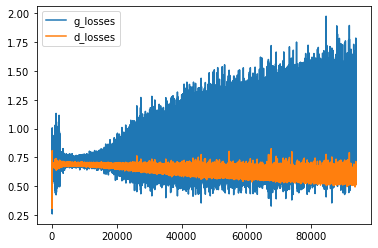

In [28]:
plt.plot(g_losses, label="g_losses")
plt.plot(d_losses, label="d_losses")
plt.legend()
plt.show()

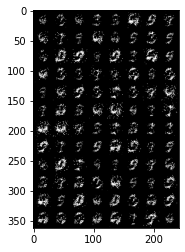

In [34]:
from skimage.io import imread
a = imread("gan_images/1.png")
plt.imshow(a)
plt.show()

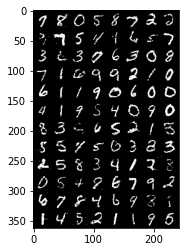

In [35]:
a = imread("gan_images/50.png")
plt.imshow(a)
plt.show()

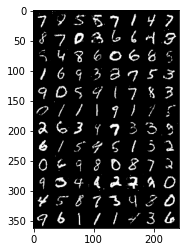

In [36]:
a = imread("gan_images/100.png")
plt.imshow(a)
plt.show()

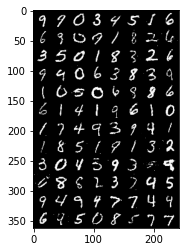

In [37]:
a = imread("gan_images/150.png")
plt.imshow(a)
plt.show()

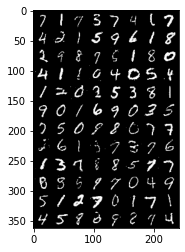

In [38]:
a = imread("gan_images/200.png")
plt.imshow(a)
plt.show()